In [28]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import os
import sys

In [2]:
from IPython.display import clear_output
from time import sleep

In [3]:
#addition module dir to path
module_dir = os.path.split( os.getcwd() )[:-1][0]
sys.path.insert(0, module_dir)

In [4]:
from src.envs.wh_env import WarehouseEnv

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [7]:
src_dir = os.getcwd()
# data_dir = '/Users/albelyakov/Data/rl_warehouse'
models_dir = os.path.join(module_dir, 'models')

In [8]:
models_dir

'/mnt/data/akuznetsov/sematic-search/rf-depo/reinforcement_learning/models'

In [9]:
from src.envs import wh_map as wm
from src.envs import wh_objects as wo

In [10]:
import subprocess
import readline

In [11]:
from keras.optimizers import Adam
from collections import Counter, deque
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau

# import tensorflow as tf

from rl.agents.dqn import DQNAgent
from rl.core import Processor
from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

Using TensorFlow backend.


In [12]:
K.tensorflow_backend._get_available_gpus()

W0723 08:16:24.810078 140379938326336 deprecation_wrapper.py:119] From /mnt/data/akuznetsov/python-ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 08:16:24.811124 140379938326336 deprecation_wrapper.py:119] From /mnt/data/akuznetsov/python-ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0723 08:16:24.811614 140379938326336 deprecation_wrapper.py:119] From /mnt/data/akuznetsov/python-ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0723 08:16:28.008170 140379938326336 deprecation_wrapper.py:119] From /mnt/data/akuznetsov/python-ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please us

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [30]:
def build_model(input_shape, n_actions):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    model.add(Dense(n_actions, activation='linear'))
    model.compile(Adam(lr=1e-3), 'mae')
    return model

In [31]:
class CustomProcessor(Processor):
    '''
    acts as a coupling mechanism between the agent and the environment
    '''

    def process_state_batch(self, batch):
        '''
        Given a state batch, I want to remove the second dimension, because it's
        useless and prevents me from feeding the tensor into my CNN
        '''
        sh = batch.shape
        return batch.reshape(-1, sh[-3], sh[-2], sh[-1])    #np.squeeze(batch, axis=1)


In [32]:
def build_callbacks(env_name):
    checkpoint_weights_filename = 'callbacks/'+'dqn_' + env_name + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format(env_name)
    callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=50000)]
    callbacks += [FileLogger(log_filename, interval=100)]
#     callbacks += [ReduceLROnPlateau(
#         monitor='val_acc', patience=5, verbose=1, factor=0.5, min_lr=1e-4
#     )]
    return callbacks

In [44]:
env = WarehouseEnv(
    map_sketch=wm.wh_map_small, 
    catalog=None, 
    num_turns=2000, 
    max_order_line=None,
    agent_max_load=200, 
    agent_max_volume=1000,
    agent_start_pos=(3, 3),
    shelf_max_load=200, 
    shelf_max_volume=100,
    frequency=0.05, 
    simplified_state=False,
    only_one_product= True, 
    win_size=(300, 200), 
    silent=True
)

In [45]:
model = build_model(input_shape=env.wh_shape, n_actions=env.action_space.n)

In [ ]:
model.load_weights('callbacks/dqn_rl-run_weights_150000.h5f')

In [47]:
processor = CustomProcessor()

In [48]:
memory = SequentialMemory(limit=64000, window_length=1)
# policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(), 
    attr='eps', 
    value_max=.7, 
    value_min=.1, 
    value_test=.05, 
    nb_steps=200000
)
dqn = DQNAgent(
    model=model, 
    nb_actions=env.action_space.n, 
    memory=memory, 
    nb_steps_warmup=1024,
    target_model_update=1e-2, 
    policy=policy, 
    processor=processor, 
    batch_size=1024
)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [49]:
callbacks = build_callbacks('rl-small')

In [50]:
%%time
hist = dqn.fit(env, nb_steps=300000, visualize=True, verbose=2, callbacks=callbacks)

Training for 300000 steps ...
done, took 76.528 seconds
CPU times: user 2min 37s, sys: 27.7 s, total: 3min 4s
Wall time: 1min 16s


In [51]:
env.close()

In [ ]:
print(hist.history.keys())

Status

In [14]:
import json

In [15]:
with open('dqn_rl-cont_log.json', 'rt') as f:
    hst = f.read()

In [17]:
hst = json.loads(hst)

In [18]:
hst.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_q', 'mean_eps', 'episode_reward', 'nb_episode_steps', 'nb_steps', 'episode', 'duration'])

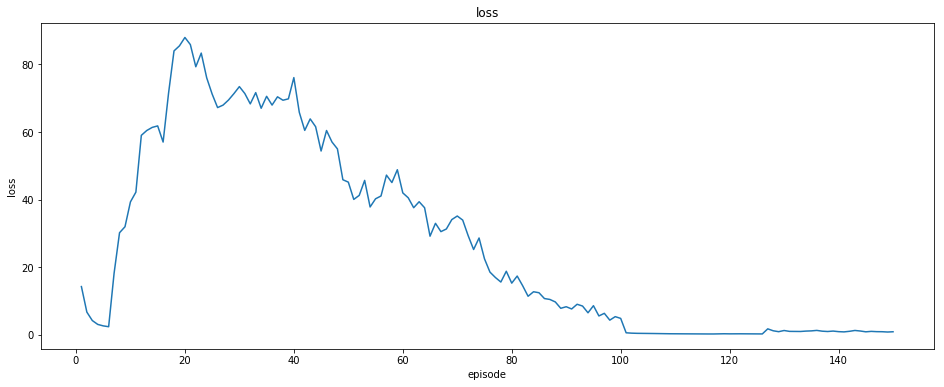

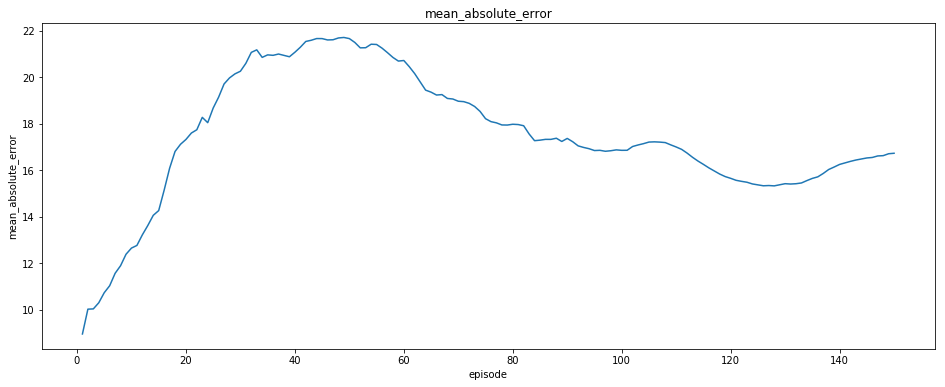

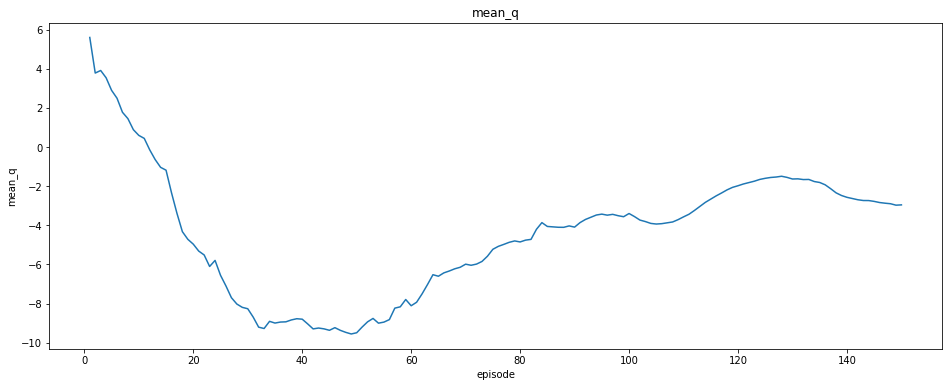

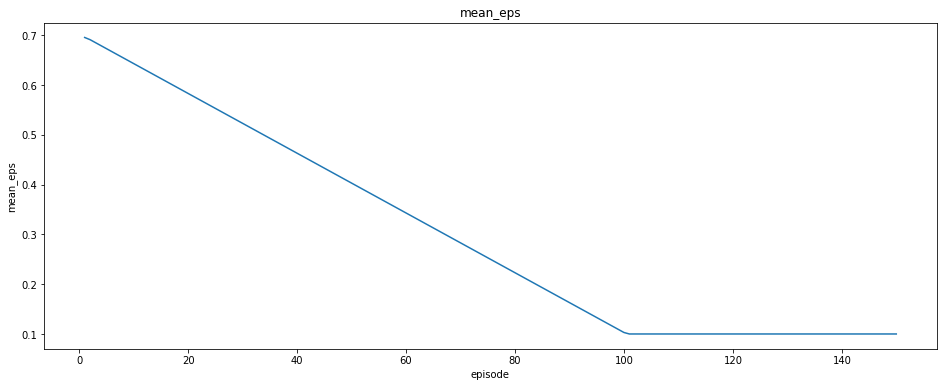

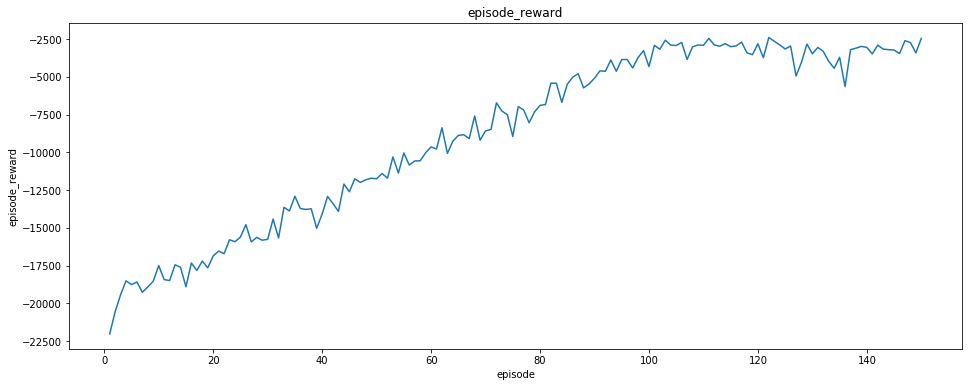

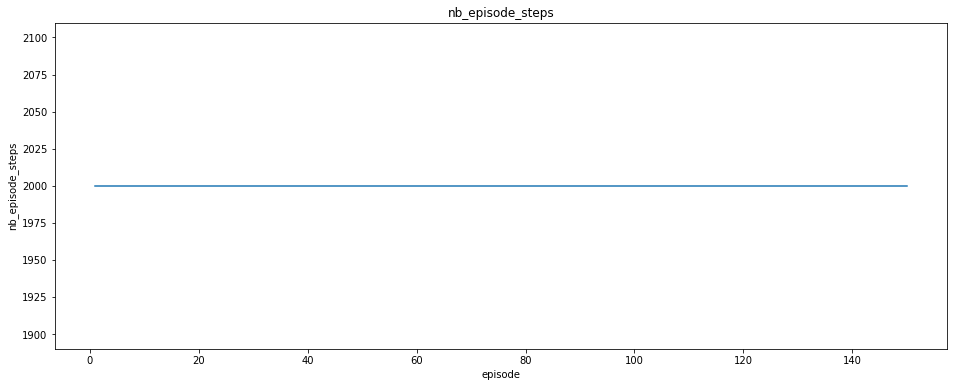

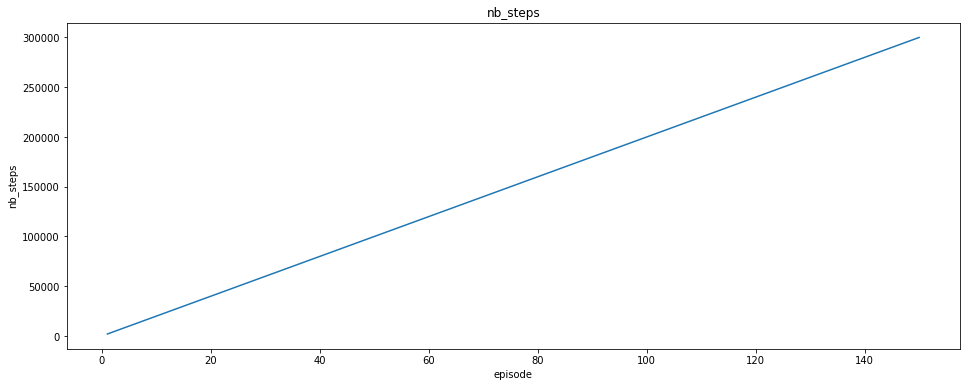

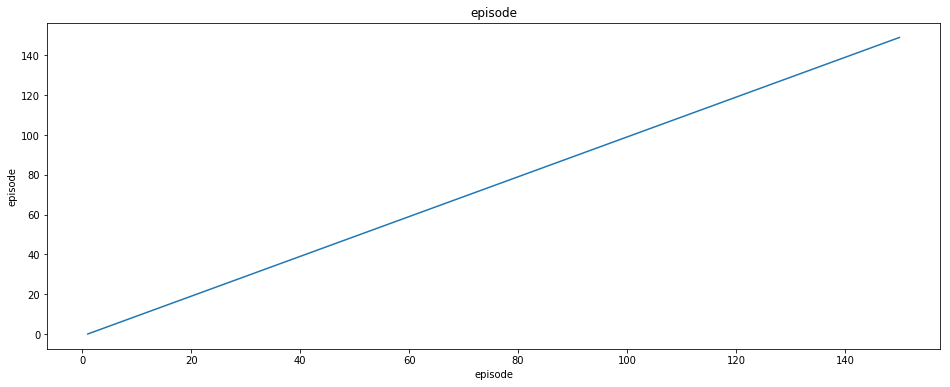

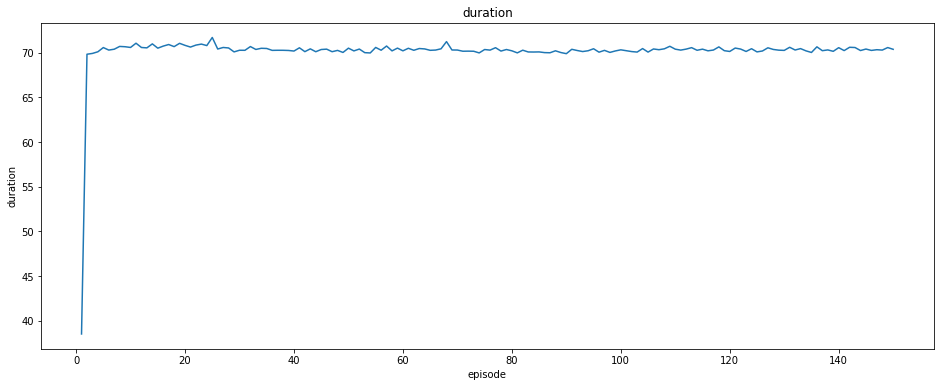

In [21]:
for key in hst.keys():
    plt.figure(figsize=(16,6))
    y = hst[key]
    x = [i+1 for i, _ in enumerate(y)]
    plt.plot(x, y)
    plt.ylabel(key)
    plt.xlabel('episode')
    plt.title(key)
    plt.show()